In [16]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
import random
#from dfply import *

%matplotlib inline

dat = pd.read_csv("/content/drive/MyDrive/Dev/vo3_q_data_x.csv")
dat2 = dat.loc[:,['cm_dummy','sex','age','gamesecond','TVwatch_day']]
dat2.head()

,cm_dummy,sex,age,gamesecond,TVwatch_day
0,0,1,44.5,0,33.427600
1,0,1,34.5,0,31.542862
2,0,1,24.5,0,37.825805
3,0,1,44.5,0,36.345911
4,0,1,34.5,0,49.344942


In [21]:
pip install sweetviz

     |████████████████████████████████| 15.1 MB 5.4 MB/s 


In [25]:
import sweetviz as sv
#from IPython.display import HTMMBL

my_report = sv.analyze(dat2)
my_report.show_html("/content/drive/MyDrive/Dev/SWEETVIZ_REPORT.html")

                                             |          | [  0%]   00:00 -> (? left)

Report /content/drive/MyDrive/Dev/SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Optimization terminated successfully.
         Current function value: 0.597929
         Iterations 5


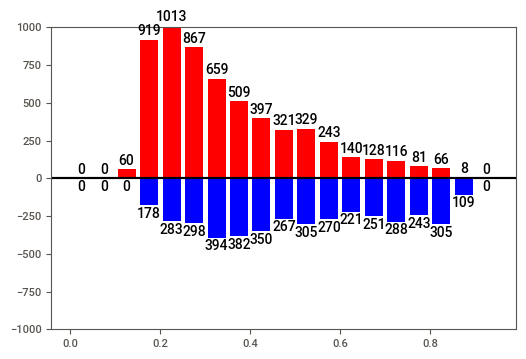

In [37]:
#傾向スコアを計算
formula = (
    "cm_dummy ~age+I(age*age)+sex+gamesecond+TVwatch_day+I(TVwatch_day*TVwatch_day)"
)
model = sm.Logit.from_formula(formula, data=dat2) 
res = model.fit()

dat2["ps"] = res.predict(dat2)

#可視化
propensity0 = dat.ps[dat2.cm_dummy==0]
propensity1 =  dat.ps[dat2.cm_dummy==1]

bins = np.arange(0, 1, 0.05)
top0, _ = np.histogram(propensity0, bins=bins)
top1, _ = np.histogram(propensity1, bins=bins)

plt.ylim(-1000,1000)
plt.axhline(0, c='black')
plt.bar(bins[:-1]+ 0.025, top0, width=0.04, facecolor='red')
plt.bar(bins[:-1]+ 0.025, -top1, width=0.04, facecolor='blue')
plt.axhline(0, c='black')

for x, y in zip(bins, top0):
    plt.text(x + 0.025, y + 10, str(y), ha='center', va='bottom')

for x, y in zip(bins, top1):
    plt.text(x + 0.025, -y - 10, str(y), ha='center', va='top')

In [38]:
#マッチングの範囲を指定
inter = np.arange(0,1,0.005)
#マッチング後のデータを入れるためのからデータフレーム
dat2_match=pd.DataFrame()

#一つ目の条件で、CM0とCM1のどちらか一方が0人の場合を除外する。
for i in inter:
    match0 = dat2[(dat2.cm_dummy==0) &(i-0.005 < dat2.ps)& (dat2.ps<i)]
    match1 = dat2[(dat2.cm_dummy==1) &(i-0.005 < dat2.ps)& (dat2.ps<i)]
   #二つ目の条件で人数が少ない方に合わせてランダムにマッチングする 
    if (match0.shape[0]!=0)&(match1.shape[0]!=0):
        if match0.shape[0]<=match1.shape[0]:
            match1= match1.iloc[random.sample(range(0,match1.shape[0]),match0.shape[0]),:]
            dat2_match = pd.concat([dat2_match,match0,match1])
        else :
            match0= match0.iloc[random.sample(range(0,match0.shape[0]),match1.shape[0]),:]
            dat2_match = pd.concat([dat2_match,match0,match1])

In [39]:
dat0 = dat2_match.query("cm_dummy==0")
dat1 = dat2_match.query("cm_dummy==1")

for i in range(1,len(dat2.columns)):
    res = stats.ttest_ind(dat0.iloc[:,i],dat1.iloc[:,i])
    diff = np.mean(dat0.iloc[:,i])-np.mean(dat1.iloc[:,i])
    col = dat0.columns[i]
    print(" {:} {:5.1f} (p: {:1.3f})".format(col,diff,res.pvalue))

 sex  -0.0 (p: 0.444)
 age  -0.2 (p: 0.540)
 gamesecond -63.6 (p: 0.865)
 TVwatch_day -18.4 (p: 0.912)
 ps   0.0 (p: 0.986)


In [ ]:
bins = np.arange(0, 1, 0.05)
top0, _ = np.histogram(dat0, bins=bins)
top1, _ = np.histogram(dat1, bins=bins)

plt.ylim(-1000,1000)
plt.axhline(0, c='black')
plt.bar(bins[:-1]+ 0.025, top0, width=0.04, facecolor='red')
plt.bar(bins[:-1]+ 0.025, -top1, width=0.04, facecolor='blue')
plt.axhline(0, c='black')

for x, y in zip(bins, top0):
    plt.text(x + 0.025, y + 10, str(y), ha='center', va='bottom')

for x, y in zip(bins, top1):
    plt.text(x + 0.025, -y - 10, str(y), ha='center', va='top')